## TTNet-Tensorflow

*Important Notes*
- Unless specified, all coordinates are in height, width, channel order.

### Imports

In [1]:
import os
import json
import shutil
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Visualize the dataset: [OpenTTGames](https://lab.osai.ai/)

The dataset contains videos of table tennis games at 120 fps. There are annotations for **events** (ball bounces, net hits, empty), ball **positions** (x, y), and **segmentation masks**. Thus, the only usable data are the images that have all of the annotations.

There are 5 videos for training and 7 videos for testing.

In [2]:
# The directories
training_data_dir = "dataset/training"
testing_data_dir = "dataset/testing"

annotations = "annotations"
segmentation_masks = "segmentation_masks"
ball_markup = "ball_markup.json"
events_markup = "events_markup.json"
images = "images"

games = os.listdir(os.path.join(training_data_dir, images))

# Configs
original_image_shape = (1080, 1920, 3) # (height, width, channels)
image_size = (128, 320, 3)
sigma = 0.6 # The sigma for the gaussian kernel
thresh_mask = 0.01 # Threshold for mask

In [3]:
def display_images(game_dir: str, game_files: str, num_frames:int = 7):
    rows, cols = 1, num_frames
    game_fig = plt.figure(figsize=(20, 10))

    for frame in range(num_frames):
        image_fp = os.path.join(game_dir, game_files[frame])
        game_1_ax = game_fig.add_subplot(rows, cols, frame+1)
        plt.imshow(plt.imread(image_fp))
        game_1_ax.set_title(f"Frame {frame+1}")
    plt.show()

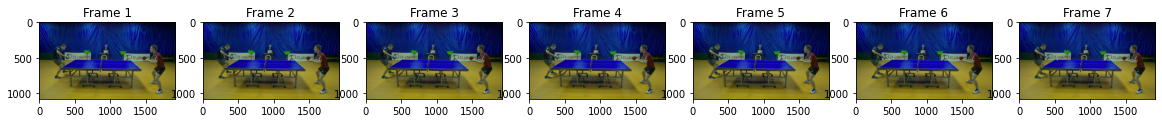

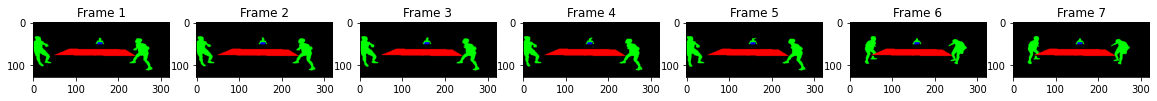

In [4]:
# Display Game 1 Data
display_images(
    game_dir=os.path.join(training_data_dir, images, games[0]),
    game_files=os.listdir(os.path.join(training_data_dir, images, games[0])))
display_images(
    game_dir=os.path.join(training_data_dir, annotations, games[0], segmentation_masks),
    game_files=os.listdir(os.path.join(training_data_dir, annotations, games[0], segmentation_masks)))

In [5]:
def get_frame_number(file_name: str):
    """Gets the frame number from file name."""
    return int(file_name.split(".")[0][len("img_"):])

def get_image_file_name(frame_number: int):
    """Gets the file name from frame number."""
    return f"img_{str(frame_number).zfill(6)}.jpg"

def get_segmentation_file_name(frame_number: int):
    """Gets the file name from frame number."""
    return f"{frame_number}.png"

*The following code is adapted from the [PyTorch Repo](https://github.com/maudzung/TTNet-Real-time-Analysis-System-for-Table-Tennis-Pytorch).*

In [6]:
def smooth_event_labeling(event_class, smooth_idx, event_frame):
    """
    Changes the event into a continuous function.
    Section 5.2 in the research paper.
    """
    target_events = np.zeros((2,))
    if event_class < 2:
        n = smooth_idx - event_frame
        target_events[event_class] = np.cos(n * np.pi / 8)
        target_events[target_events < 0.01] = 0.
    return target_events

In [7]:
smooth_labeling = True
num_frames = 9
num_frames_from_event = int((num_frames - 1) / 2)
events_dict = {
        "bounce": 0,
        "net": 1,
        "empty_event": 2
    }

def load_data(game_list: list):
    """Prepares the dataset with list of images (inputs) and labels (targets).
    Parameters:
        game_list: list 
            List of the game directories.
    Returns:
        event_labels: list
            List of the event labels 0 - 2; see events dict.
        event_info: list
            List of the event info; [image_path_list, ball_position, target_events, segmentation_path].
    """
    event_labels, event_info = [], []
    for game in game_list:
        ball_annotation_path = os.path.join(training_data_dir, annotations, game, ball_markup)
        events_annotation_path = os.path.join(training_data_dir, annotations, game, events_markup)

        ball_annotation = json.load(open(ball_annotation_path))
        events_annotation = json.load(open(events_annotation_path))
        for event_frame, event_name in events_annotation.items():
            event_frame = int(event_frame)
            smooth_frame_indices = [event_frame]
            if (event_name != "empty_event") and smooth_labeling: # If it isn't an empty event, i.e. a "net" or "bounce" then we use smooth labeling
                smooth_frame_indices = [frame for frame in range(event_frame - num_frames_from_event, event_frame + num_frames_from_event + 1)]

            for smooth_frame_index in smooth_frame_indices:
                smoothed_frames = [frame for frame in range(event_frame - num_frames_from_event, event_frame + num_frames_from_event + 1)]
                image_path_list = []
                for smooth_frame in smoothed_frames:
                    image_path_list.append(os.path.join(training_data_dir, images, game, get_image_file_name(smooth_frame)))
                last_frame = smooth_frame_index + num_frames_from_event
                if f"{last_frame}" not in ball_annotation.keys(): # Get the ball position of the last frame
                    continue
                ball_position = ball_annotation[f"{last_frame}"]
                ball_position = np.array([ball_position["y"], ball_position["x"]], dtype=np.int32)
                if (ball_position[0] < 0) or (ball_position[1] < 0): # Remove the frame if the ball is not in the frame
                    continue
                segmentation_path = os.path.join(training_data_dir, annotations, game, segmentation_masks, get_segmentation_file_name(smooth_frame_index))
                if os.path.isfile(segmentation_path) == False: # Check if the segmentation mask exists
                    # print(f"The segmentation path does not exist: {segmentation_path}")
                    continue
                event_class = events_dict[event_name]
                target_events = smooth_event_labeling(event_class, smooth_frame_index, event_frame)
                if (target_events[0] == 0) and (target_events[1] == 0):
                    event_class = 2
                
                event_labels.append(event_class)
                event_info.append([image_path_list, ball_position, target_events, segmentation_path])
    return event_info, event_labels

In [8]:
raw_data, raw_event = load_data(games)
print(f"Images: {raw_data[0][0]} \n",
      f"Position: {raw_data[0][1]} \n",
      f"Events: {raw_data[0][2]} \n",
      f"Segmentation Path: {raw_data[0][3]} \n",
      f"Label: {raw_event[0]}")

Images: ['dataset/training\\images\\game_1\\img_000014.jpg', 'dataset/training\\images\\game_1\\img_000015.jpg', 'dataset/training\\images\\game_1\\img_000016.jpg', 'dataset/training\\images\\game_1\\img_000017.jpg', 'dataset/training\\images\\game_1\\img_000018.jpg', 'dataset/training\\images\\game_1\\img_000019.jpg', 'dataset/training\\images\\game_1\\img_000020.jpg', 'dataset/training\\images\\game_1\\img_000021.jpg', 'dataset/training\\images\\game_1\\img_000022.jpg'] 
 Position: [544 566] 
 Events: [0. 0.] 
 Segmentation Path: dataset/training\annotations\game_1\segmentation_masks\14.png 
 Label: 2


*The following code is custom.*

After loading the data: we should read the raw data and transform into usable tensors for training.

- For image data, load the images and resize to (320, 128).
- For ball position data, create a target construction of the ball location with "two one-dimensional Gaussian distribution curves with means associated with the x and y of the ball center, rescpectively. The variances of the two curves are set to reasonable values associated with the average ball radius at the scale of the fed frames" (Voeikov Et al., 2020).
- For segmentation masks, simply load the masks as tensors.
- For event labels, one-hot encode the labels.

**Image Data Processing**

In [9]:
def process_images(image_path_list: list):
    """Processes the images to be ready for training."""
    processed_images = []
    for image_path in image_path_list:
        bytes_image = tf.io.read_file(image_path)
        image = tf.io.decode_image(bytes_image)
        image = tf.image.resize(image, (image_size[0], image_size[1]))
        processed_images.append(image)
    return np.array(processed_images, dtype=np.float32) / 255.

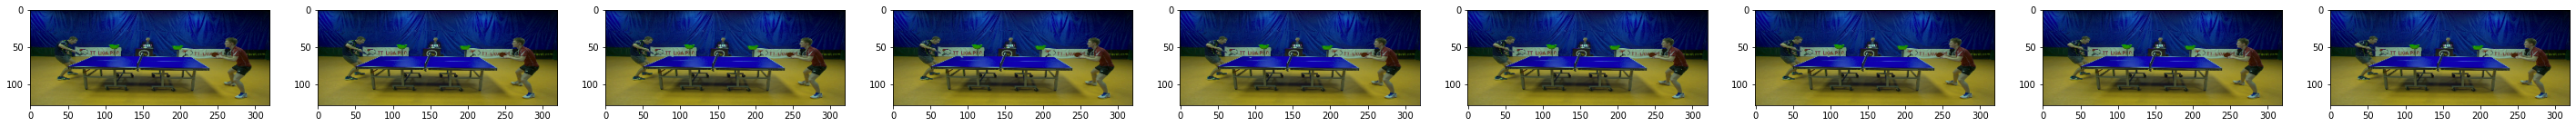

In [10]:
processed_images = process_images(raw_data[0][0])
figure = plt.figure(figsize=(50, 90))

for i, image in enumerate(processed_images):
    figure.add_subplot(1, len(list(processed_images)), i+1)
    plt.imshow(image)
plt.show()

**Ball Position Data Processing**

In [11]:
def gaussian_1d(pos, muy, sigma):
    """Create 1D Gaussian distribution based on ball position (muy), and std (sigma)"""
    target = tf.math.exp(- (((pos - muy) / sigma) ** 2) / 2)
    return target

def process_ball_position(ball_position: list, sigma: int, image_size: tuple):
    """Processes the ball position to be ready for training.
    Parameters:
        ball_position: list
            List of the ball position.
        sigma: float
            Standard deviation of the Gaussian distribution (for the ball).
        image_size: tuple
            Size of the image (h, w).
    Returns:
        target: list
            Ball gaussian position [0:w] x-position, [w:] y-position.
    """
    ball_position = ball_position.copy()

    width, height = int(image_size[1]), int(image_size[0])
    target_position = np.zeros(width + height)

    ball_position[0] = float((ball_position[0] / original_image_shape[0]) * height)
    ball_position[1] = float((ball_position[1] / original_image_shape[1]) * width)


    if (width > ball_position[1]) and (height > ball_position[0]):
        x = tf.range(0, width, dtype=tf.float32)
        target_position[:width] = gaussian_1d(x, ball_position[1], sigma=sigma)
        y = tf.range(0, height, dtype=tf.float32)
        target_position[width:] = gaussian_1d(y, ball_position[0], sigma=sigma)

        target_position[target_position < thresh_mask] = 0
    return target_position, ball_position

In [12]:
gaussian_position, scaled_position = process_ball_position(raw_data[0][1], sigma, image_size)

print(f"Ball Position: {scaled_position}")
print(f"Gaussian Position: {gaussian_position}")

Ball Position: [64 94]
Gaussian Position: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24935223 1.         0.24935223
 0.   

In [13]:
print(raw_data[0][1])

[544 566]


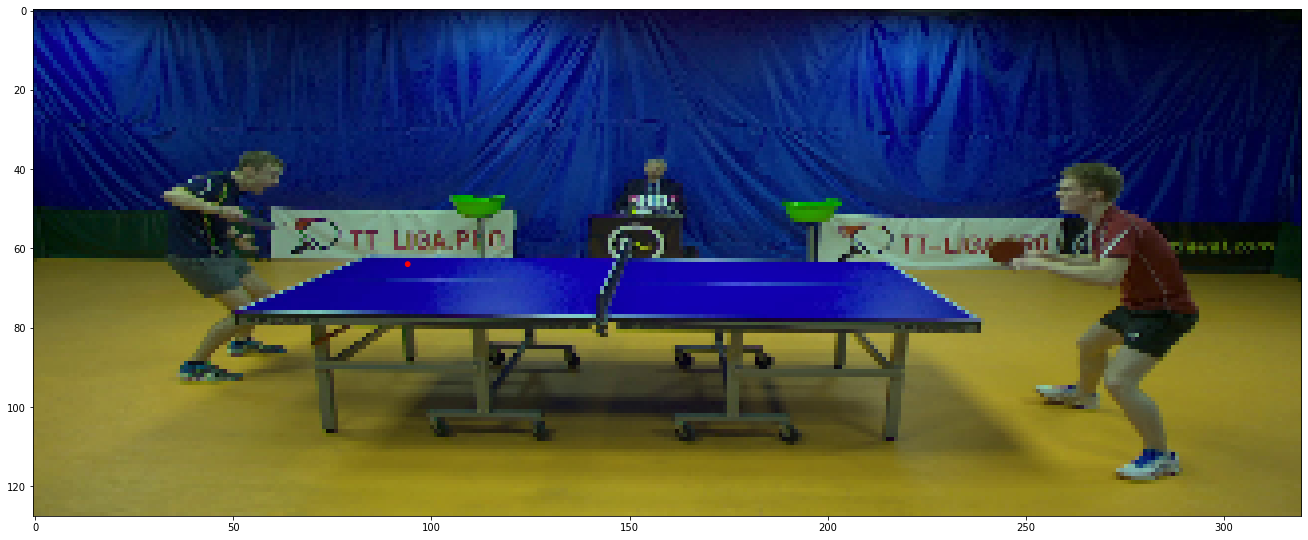

In [14]:
figure = plt.figure(figsize=(50, 100))
figure.add_subplot(1, 2, 1)
plt.imshow(tf.image.resize(plt.imread(raw_data[0][0][8]), (image_size[0], image_size[1])) / 255.)
ball = plt.Circle((scaled_position[1], scaled_position[0]), radius=sigma, color="red")
plt.gca().add_artist(ball)

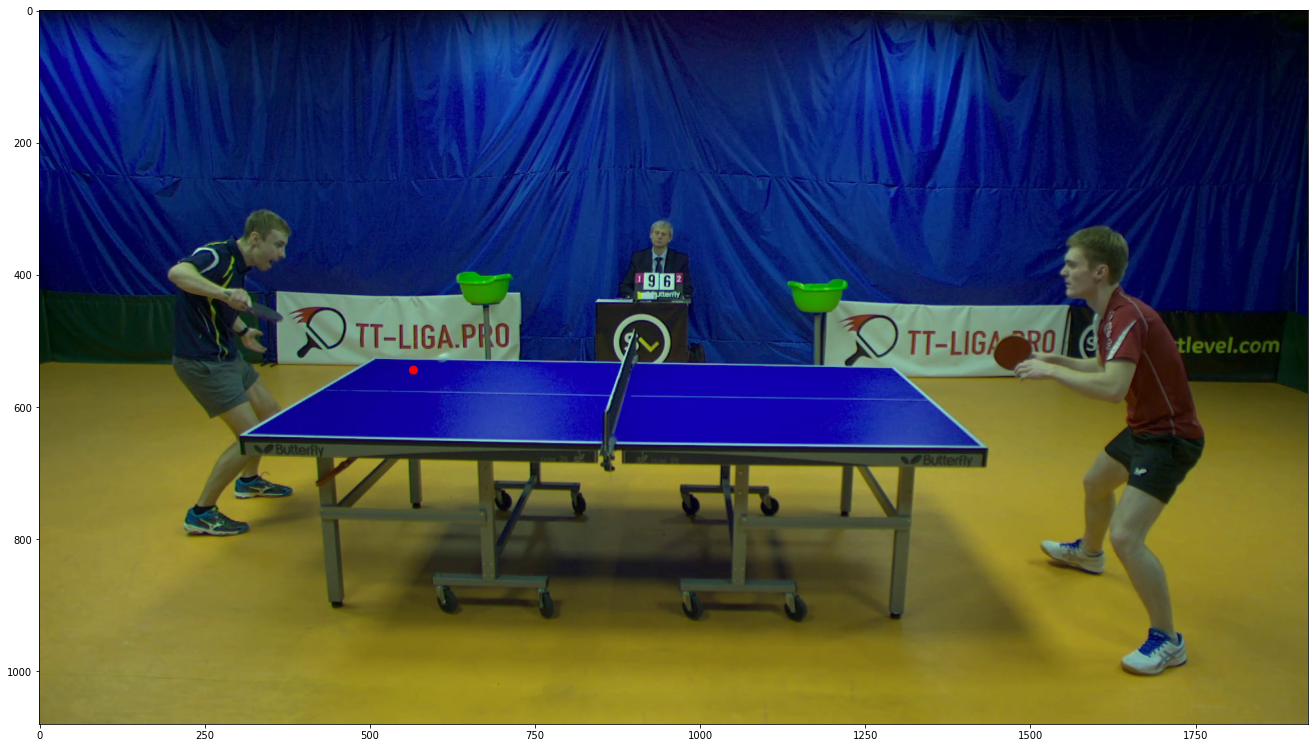

In [20]:
figure = plt.figure(figsize=(50, 100))
figure.add_subplot(1, 2, 1)
plt.imshow(plt.imread(raw_data[0][0][8]))
ball = plt.Circle((raw_data[0][1][1], raw_data[0][1][0]), radius=sigma*10, color="red")
plt.gca().add_artist(ball)

**Segmentation Mask Data Processing**

- R: Score Board (255, 0, 0)
- G: Persons (0, 255, 0)
- B: Table (0, 0, 255)

*The following function is from [PSPNet-Tensorflow](https://github.com/IdeaKing/PSPNet-Tensorflow/blob/main/dataset.py)*

In [16]:
def one_hot_encode_mask(mask, palette):
    """
    Converts mask to a one-hot encoding specified by the semantic map.
    """
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map

In [25]:
def process_masks(mask_path: str, palette: list):
    """Processes the images to be ready for training."""
    processed_masks = []
    bytes_mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_image(bytes_mask)
    mask = tf.image.resize(mask, (image_size[0], image_size[1]))
    mask = one_hot_encode_mask(mask, palette)
    processed_masks.append(mask)
    return np.array(processed_masks, dtype=np.float32)

In [26]:
palette = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]
masks = process_masks(raw_data[0][3], palette)

In [28]:
print(masks.shape)
print(masks)

(1, 128, 320, 4)
[[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  ...

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]


Build the tf.Data pipeline